In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import Tensor
import abc
from torch.distributions import MultivariateNormal, Poisson
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torch.nn import Module
from torch import nn
from torch.optim.lr_scheduler import StepLR
from main import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import pickle
from scipy.interpolate import CubicSpline

torch.set_default_dtype(torch.float64)

from sklearn.metrics import r2_score
import dill

In [2]:
# 20160630

# z_train_filter = np.load('new_params/z_hat_20min_filter.npy')
# plt.plot(z_train_filter[0, :, :100].T)
# plt.show()

# z_train_smooth = np.load('new_params/z_hat_20min_smooth.npy')
# plt.plot(z_train_smooth[0, :, :100].T)
# plt.show()

In [3]:
# dataset = '4g10'
dataset = 'Doherty'
smoothing = True
new = False
z_train = None
if dataset == '4g10':
    data = np.load('data_10ms.npz')
    v_train = Tensor(data['hand_train'].transpose(1,0,2))
    v_test = Tensor(data['hand_test'].transpose(1,0,2))
    Y_train = Tensor(data['neural_train'].transpose(1,0,2))
    Y_test = Tensor(data['neural_test'].transpose(1,0,2))
    print(v_train.shape, v_test.shape, Y_train.shape, Y_test.shape)
    T_trial = 0.01 # 10ms

    p = pickle.load(open('4g10preprocess/10ms.pkl', 'rb'))
    # rec_model = dill.load(open('4g10datamodels/first_10ms_rec.pkl', 'rb'))
    m = dill.load(open('4g10datamodels/first_10ms.pkl', 'rb'))
    rec_model = dill.load(open('4g10datamodels/first_10ms_rec_online.pkl', 'rb'))
    gen_model = rec_model.gen_model

elif dataset == 'Doherty':
    # p = pickle.load(open('new_params/_1t.pkl', 'rb'))
    # z_train = np.load('new_params/z_hat_20min_smooth.npy')

    # p = pickle.load(open('new_params/9k1t.pkl', 'rb'))
    # m = dill.load(open('bgpfa_models/shifted.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/shifted_rec.pkl', 'rb'))

    # m = dill.load(open('bgpfa_models/9k.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/9k_rec.pkl', 'rb'))

    # m = dill.load(open('bgpfa_models/9ktrain_5kpre.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/9ktrain_5kpre_rec.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/9ktrain_5kpre_rec_CD.pkl', 'rb'))

    # m = dill.load(open('bgpfa_models/9ktrain_5kpreNB.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/9ktrain_5kpre_NB_rec.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/9ktrain_5kpre_NB_CD_rec.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/9ktrain_5kpre_NB_new_CD_rec.pkl', 'rb'))

    # m = dill.load(open('bgpfa_models/320NB.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/320NB_rec.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/320NB_CD_AB_rec.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/320NB_CD_ABp_rec.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/320NB_CD_ABp_smallrnn_rec.pkl', 'rb'))

    # m = dill.load(open('bgpfa_models/320NB_400t.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/320NB_400t_CD_ABp_rec.pkl', 'rb'))
    
    # m = dill.load(open('bgpfa_models/gen_train.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/gen_train_rec.pkl', 'rb'))

    # m = dill.load(open('bgpfa_models/320NB_filt.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/320NB_filt_rec.pkl', 'rb'))
    
    # p = pickle.load(open('new_params/5k_20z.pkl', 'rb'))
    # z_train = np.load('new_params/z_hat_5k_20z.npy')
    # m = dill.load(open('bgpfa_models/5k_20z.pkl', 'rb'))
    # # rec_model = dill.load(open('bgpfa_models/5k_20z_rec.pkl', 'rb'))

    # rec_model = dill.load(open('bgpfa_models/5k_20z_rec_new.pkl', 'rb'))
    new = True
    

    # p = pickle.load(open('new_params/5k_30z.pkl', 'rb'))
    # z_train = np.load('new_params/z_hat_5k_30z.npy')
    # m = dill.load(open('bgpfa_models/5k_30z.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/5k_30z_rec.pkl', 'rb'))

    p = pickle.load(open('new_params/_1t.pkl', 'rb'))
    z_train = np.load('new_params/z_hat_20min_smooth.npy')
    # m = dill.load(open('bgpfa_models/5k_10z_notshifted_poisson_noCD.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/5k_10z_notshifted_poisson_noCD_rec_best.pkl', 'rb'))
    m = dill.load(open('bgpfa_models/5k_10z_poisson_noCD2.pkl', 'rb'))
    rec_model = dill.load(open('bgpfa_models/5k_10z_poisson_noCD_rec2.pkl', 'rb'))

    gen_model = rec_model.gen_model
    data_len = 69800
    trial_len = rec_model.gen_model.Y.shape[-1]
    train_len = 12800
    # test_trial_len = data_len - train_len
    test_trial_len = 1000

    data = pickle.load(open('data/Doherty_example.pickled', 'rb')) # load example data
    binsize = 25 # binsize in ms
    T_trial = 0.025 # 25ms
    start = 0
    timepoints = np.arange(start, data_len+start) #subsample ~40 seconds of data so things will run somewhat quicker
    # print(data['Y'].shape)
    fit_data = {'Y': data['Y'][..., timepoints], 'locs': data['locs'][timepoints, :], 'targets': data['targets'][timepoints, :], 'binsize': binsize}
    Y = fit_data['Y'] # these are the actual recordings and is the input to our model
    targets = fit_data['targets'] # these are the target locations
    locs = fit_data['locs'] # these are the hand positions

    # Y = Y[:, np.mean(Y,axis = (0, 2))/0.025 > 2, :] #subsample highly active neurons so things will run a bit quicker
    Y = Y[:, np.mean(Y,axis = (0, 2))/0.025 > 0, :]
    # print(Y.shape)
    ntrials, n, T = Y.shape # Y should have shape: [number of trials (here 1) x neurons x time points]

    ts = np.arange(Y.shape[-1])*fit_data['binsize'] # measured in ms
    cs = CubicSpline(ts, locs) # fit cubic spline to behavior
    delay = 120
    vels = cs(ts+delay, 1) # velocity (first derivative)
    v = Tensor(vels.T[None, ...])
    def convert_to_trials(_Y, _z=None, _v=None, t=None):
        assert _Y.shape[-1] % t == 0
        N = _Y.shape[1]
        ntrials = _Y.shape[-1] // t
        Y = _Y.transpose(1,0,2).reshape(N,ntrials,-1).transpose(1,0,2)
        z = None
        if _z is not None:
            b = _z.shape[1]
            z = _z.transpose(1,0,2).reshape(b,ntrials,-1).transpose(1,0,2)
        v = None
        if _v is not None:
            b_v = _v.shape[1]
            v = _v.permute(1,0,2).reshape(b_v,ntrials,-1).permute(1,0,2)
        return Y, z, v

    print(Y.shape, 'original Y shape')
    Y_train = Y[..., :train_len]
    # z_train = z[..., :train_len]
    v_train = v[..., :train_len]
    Y_test = Y[..., train_len:]
    # z_test = z[..., train_len:]
    v_test = v[..., train_len:]

    z_train = z_train[:,:,:train_len]

    Y_train, z_train, v_train = convert_to_trials(Y_train, z_train, v_train, trial_len)
    Y_test, _, v_test = convert_to_trials(Y_test, None, v_test, test_trial_len)
    Y_train = Tensor(Y_train)
    Y_test = Tensor(Y_test)
    print(Y_train.shape, v_train.shape, 'y_train, v_train shape')
    print(Y_test.shape, v_test.shape, 'y_test, v_test shape')



(1, 200, 69800) original Y shape
torch.Size([128, 200, 100]) torch.Size([128, 2, 100]) y_train, v_train shape
torch.Size([57, 200, 1000]) torch.Size([57, 2, 1000]) y_test, v_test shape


In [4]:
# plt.plot(v_test[:,0,:].flatten())
# plt.plot(v_test[:,1,:].flatten())
# plt.show()

# plt.plot(torch.mean(Y_test, axis=1).flatten())

In [5]:
# z_train_filter = p.get_z_hat(v_train, smoothing=True).detach().cpu().numpy()
# print(z_train_filter.shape)
# np.save('new_params/z_hat_5k_30z.npy', z_train_filter)

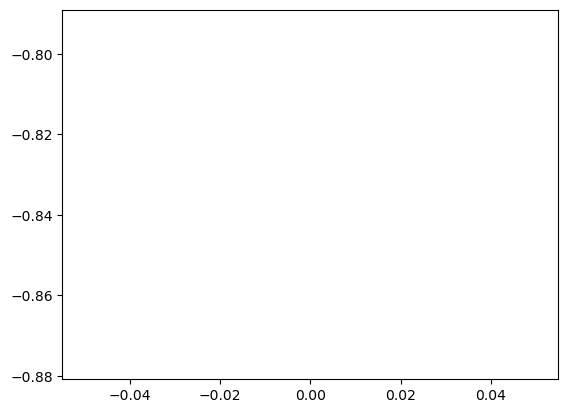

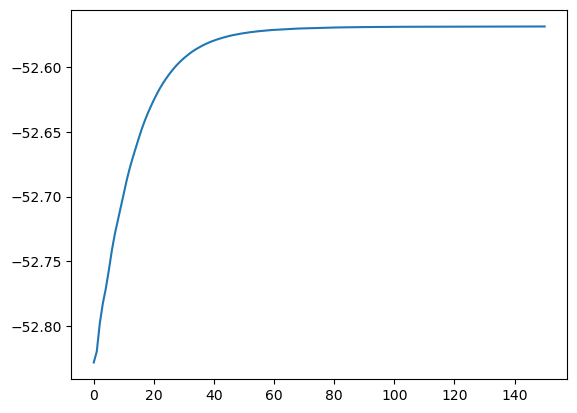

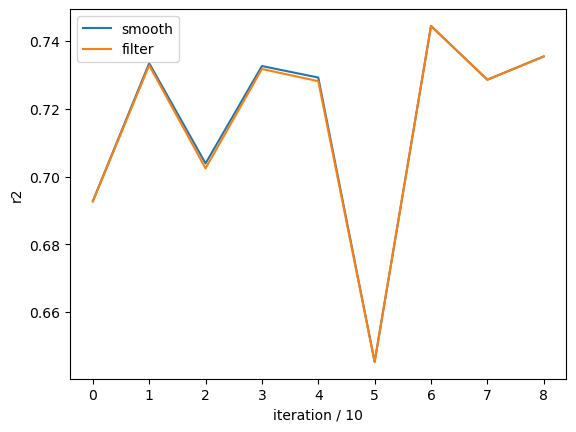

In [6]:
plt.plot(rec_model.LLs[100:])
plt.show()
plt.plot(gen_model.LLs[:])
plt.show()

if new:
    start = 2
    plt.plot(rec_model.r2_smooth[start:], label='smooth')
    plt.plot(rec_model.r2_filt[start:], label='filter')
    plt.legend()
    plt.xlabel('iteration / 10')
    plt.ylabel('r2')
    plt.show()

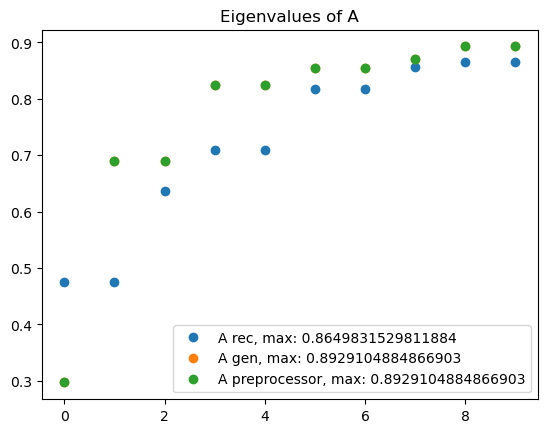

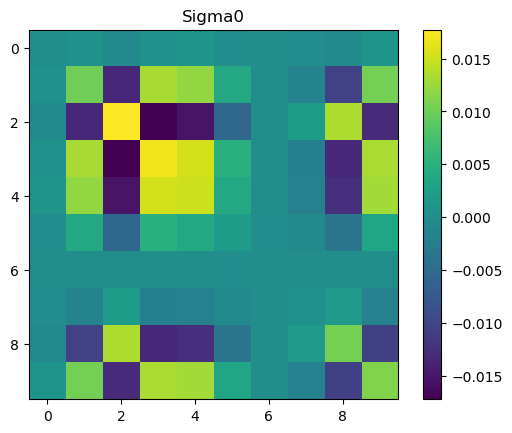

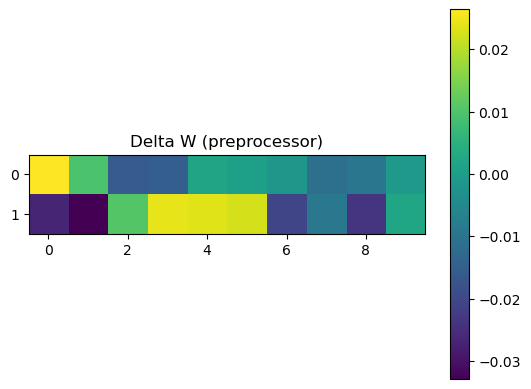

tensor([[ 5.4237e-06, -1.5079e-06],
        [-1.5079e-06,  6.6393e-06]], device='cuda:0', grad_fn=<AddBackward0>) tensor([[3.1788e-06, 9.3212e-07],
        [9.3212e-07, 3.1250e-06]], device='cuda:0')


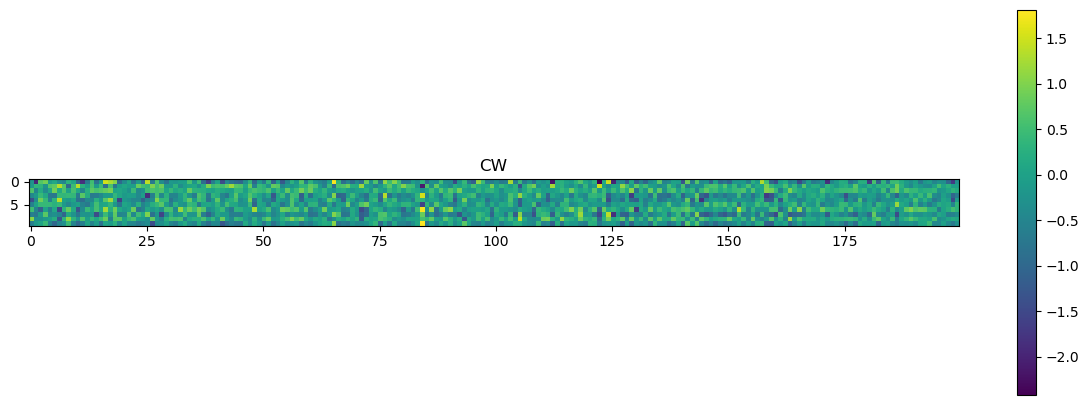

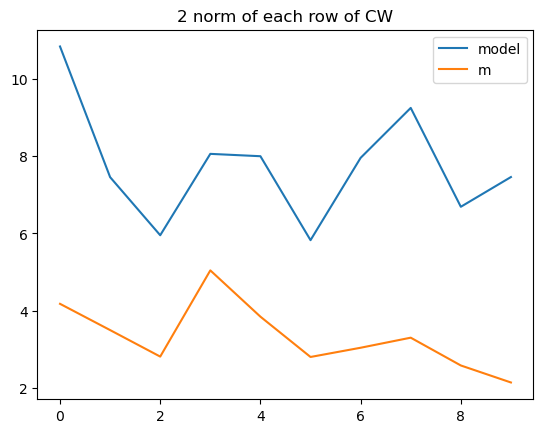

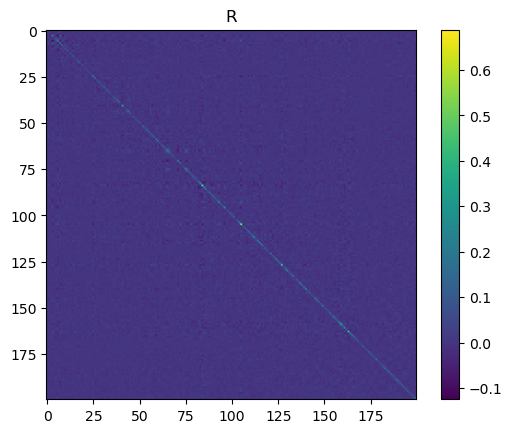

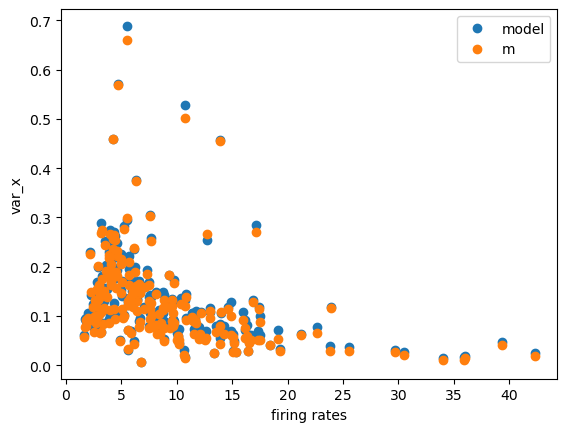

Text(0, 0.5, 'd')

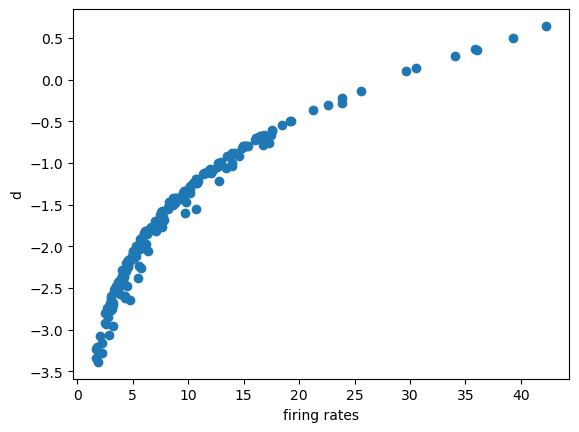

In [7]:
eigs = sorted(np.abs(np.linalg.eigvals(gen_model.A[0].detach().cpu().numpy())))
plt.plot(eigs, 'o', label='A rec, max: {}'.format(np.max(eigs)))
eigs = sorted(np.abs(np.linalg.eigvals(m.A[0].detach().cpu().numpy())))
plt.plot(eigs, 'o', label='A gen, max: {}'.format(np.max(eigs)))
eigs = sorted(np.abs(np.linalg.eigvals(p.A.detach().cpu().numpy())))
plt.plot(eigs, 'o', label='A preprocessor, max: {}'.format(np.max(eigs)))
plt.legend()
plt.title('Eigenvalues of A')
plt.show()

plt.imshow(p.Sigma0.detach().cpu().numpy())
plt.colorbar()
plt.title('Sigma0')
plt.show()
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# ax[0].imshow(rec_model.preprocessor.W.detach().cpu().numpy())
# ax[0].set_title('W new')
# ax[1].imshow(p.W.detach().cpu().numpy())
# ax[1].set_title('W orig')
# plt.show()
plt.imshow(rec_model.preprocessor.W.detach().cpu().numpy() - p.W.detach().cpu().numpy())
plt.colorbar()
plt.title('Delta W (preprocessor)')
plt.show()

print(rec_model.preprocessor.R, p.R)

# plt.imshow(gen_model.A[0].detach().cpu().numpy() - m.A[0].detach().cpu().numpy())
# plt.colorbar()
# plt.title('Delta A')
# plt.show()

# plt.imshow(gen_model.Q[0].detach().cpu().numpy() - m.Q[0].detach().cpu().numpy())
# plt.colorbar()
# plt.title('Delta Q')
# plt.show()

plt.figure(figsize=(15, 5))  # Adjust as needed
plt.imshow((gen_model.C @ gen_model.W)[0].detach().cpu().numpy().T)
plt.colorbar()
plt.title('CW')
plt.show()

# plt.figure(figsize=(15, 5))  # Adjust as needed
# # m = dill.load(open('4g10datamodels/new_full_R.pkl', 'rb'))
# plt.imshow((m.C @ m.W)[0].detach().cpu().numpy().T)
# plt.colorbar()
# plt.title('CW (orig gen model)')
# plt.show()

# plt.figure(figsize=(15, 5))  # Adjust as needed
# plt.imshow((m.C @ m.W)[0].detach().cpu().numpy().T - (gen_model.C @ gen_model.W)[0].detach().cpu().numpy().T)
# plt.colorbar()
# plt.title('CW delta')
# plt.show()

# plot 2 norm of each row of CW
plt.plot(torch.linalg.norm((gen_model.C @ gen_model.W)[0], dim=0).detach().cpu().numpy(), label='model')
plt.plot(torch.linalg.norm((m.C @ m.W)[0], dim=0).detach().cpu().numpy(), label='m')
plt.legend()
plt.title('2 norm of each row of CW')
plt.show()

plt.imshow(gen_model.R.squeeze(0).detach().cpu().numpy())
plt.colorbar()
plt.title('R')
plt.show()

# # plot Delta R between model and m
# plt.imshow((model.R.squeeze(0) - m.R.squeeze(0)).detach().cpu().numpy())
# plt.colorbar()
# plt.title('Delta R')
# plt.show()

plt.plot(Y_train.mean(dim=(0,2))/T_trial, torch.diag(gen_model.R.squeeze()).detach().cpu().numpy(), 'o', label='model')
plt.plot(Y_train.mean(dim=(0,2))/T_trial, torch.diag(m.R.squeeze()).detach().cpu().numpy(), 'o', label='m')
plt.legend()
plt.xlabel('firing rates')
plt.ylabel('var_x')
plt.show()


plt.plot(Y_train.mean(dim=(0,2))/T_trial, gen_model.d.detach().cpu().numpy(), 'o')
plt.xlabel('firing rates')
plt.ylabel('d')

/home/ayush/anaconda3/lib/python3.11/site-packages/torch/nn/modules/rnn.py:509: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.rnn_tanh(input, hx, self._flat_weights, self.bias, self.num_layers,


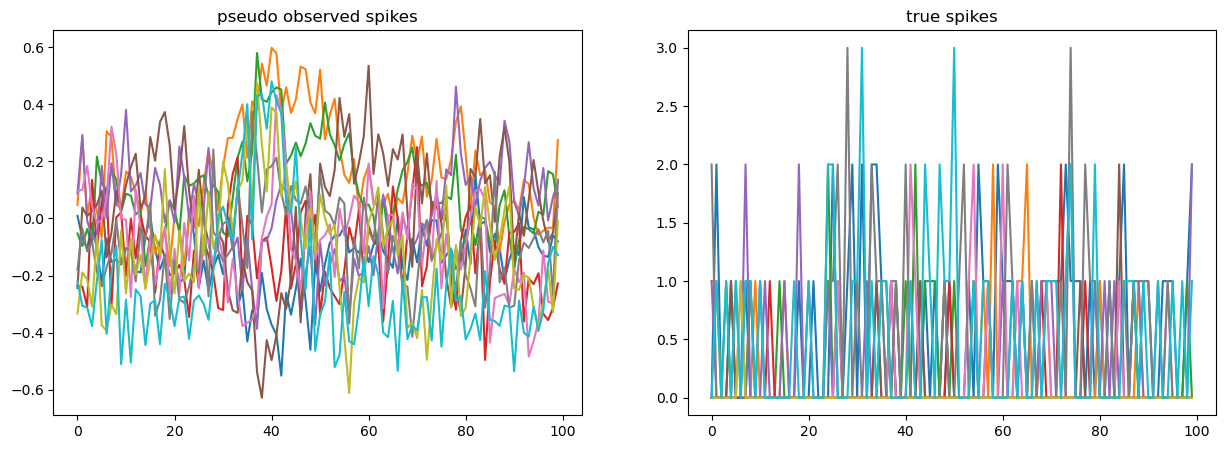

In [8]:
neural_net = rec_model.neural_net
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
for n in range(10):
    ax[0].plot(neural_net(rec_model.gen_model.Y.transpose(1, 2)).transpose(1,2)[0, n, :].detach().cpu().numpy())
    # ax[0].plot(neural_net(rec_model.gen_model.Y.transpose(1, 2))['x_tilde'].transpose(1,2)[0, n, :].detach().cpu().numpy())
# plt.show()
for n in range(10):
    ax[1].plot(Y_train[0, n, :].detach().cpu().numpy())   
ax[0].set_title('pseudo observed spikes')
ax[1].set_title('true spikes')
plt.show()

In [9]:
rec_model.freeze_params()
torch.cuda.empty_cache()
z_train_inferred, z_train_inferred_samps = rec_model.test_z(rec_model.gen_model.Y, smoothing=smoothing, samples=100, batch=25)
# z_train_inferred, z_train_inferred_samps = z_train_inferred.detach().cpu().numpy(), z_train_inferred_samps.detach().cpu().numpy()
torch.cuda.empty_cache()
z_test_inferred, z_test_inferred_samps = rec_model.test_z(Y_test.to(device), smoothing=smoothing, samples=1)
# z_test_inferred, z_test_inferred_samps = z_test_inferred.detach().cpu().numpy(), z_test_inferred_samps.detach().cpu().numpy()
torch.cuda.empty_cache()
print(z_train_inferred.shape, z_test_inferred.shape, 'z_train_inferred, z_test_inferred shape')

v_train_inferred = (rec_model.preprocessor.W.detach().cpu().numpy() @ z_train_inferred)
v_test_inferred = (rec_model.preprocessor.W.detach().cpu().numpy() @ z_test_inferred)
print(v_train_inferred.shape, v_test_inferred.shape, 'v_train_inferred, v_test_inferred shape')


(128, 10, 100) (57, 10, 1000) z_train_inferred, z_test_inferred shape
(128, 2, 100) (57, 2, 1000) v_train_inferred, v_test_inferred shape


In [10]:
_nsamps, _ntrials, _N, _T = z_train_inferred_samps.shape
z_train_inferred_samps = z_train_inferred_samps.transpose(0,2,1,3).reshape((_nsamps, _N, _T*_ntrials))[:, None, ...]

_nsamps, _ntrials, _N, _T = z_test_inferred_samps.shape
z_test_inferred_samps = z_test_inferred_samps.transpose(0,2,1,3).reshape((_nsamps, _N, _T*_ntrials))[:, None, ...]

print(z_train_inferred_samps.shape, z_test_inferred_samps.shape)

(100, 1, 10, 12800) (1, 1, 10, 57000)


In [11]:
# zz_dim = 2
# train_start = 1200
# train_end = 1600

# for zz in range(10):
#     for s in range(z_test_inferred_samps.shape[0]):
#         plt.plot(z_train_inferred_samps[s, :, zz, :].flatten()[train_start:train_end], alpha=0.1)
#     plt.plot(z_train_inferred[:, zz, :].flatten()[train_start:train_end], label='inferred')
#     plt.plot(z_train_inferred_samps[:, :, zz, :].mean(axis=0).flatten()[train_start:train_end], label='sample mean')
#     # plt.plot(z_train_inferred_samps[:, 0, zz, :100].T, alpha=0.1)
#     plt.legend()
#     plt.title('Train')
#     plt.show()

# plt.plot(z_test_inferred[0, zz_dim, :100], label='inferred')
# plt.plot(z_test_inferred_samps[:, 0, zz_dim, :100].T, alpha=0.1)
# plt.plot(z_test_inferred_samps[:, 0, zz_dim, :100].mean(axis=0), label='sample mean')
# plt.legend()
# plt.title('Test')
# plt.show()

# # fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# # ax[0].plot(z_train_inferred[0, :, :100].T)
# # ax[0].set_title('Train inferred')
# # ax[1].plot(z_train_inferred_samps[:, 0, :, :100].mean(axis=0).T)
# # ax[1].set_title('Train inferred sample mean')
# # plt.show()

# # plt.plot(z_train_inferred[0, :, :100].T)
# # # plt.plot(z_train_inferred_samps[:, 0, :, :100].T, alpha=0.1)
# # plt.plot(z_train_inferred_samps[:, 0, :, :100].mean(axis=0).T, linestyle='--')
# # plt.show()

torch.Size([100, 1, 200, 12800]) f samps shape


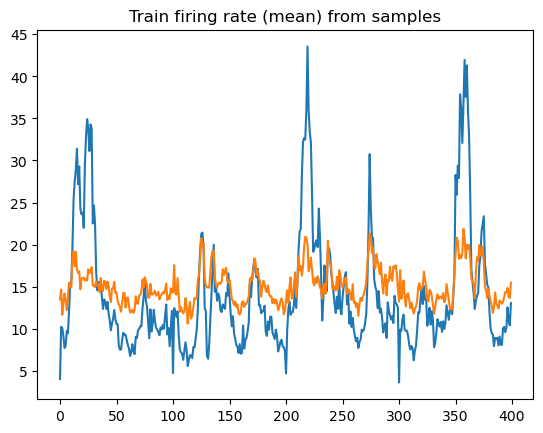

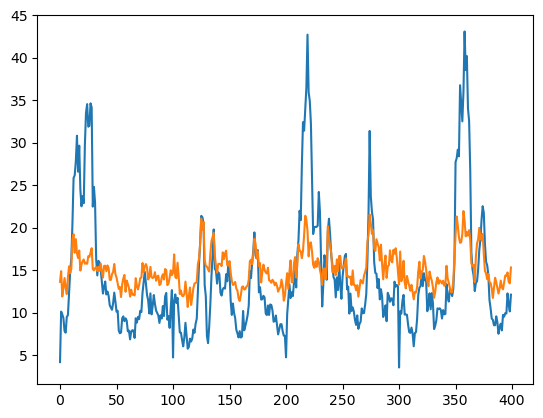

torch.Size([57000])
torch.Size([57000])


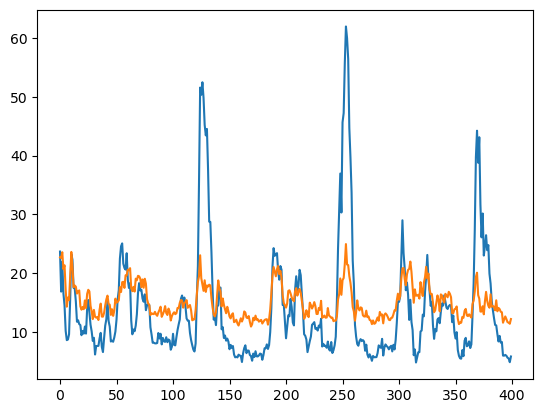

torch.Size([1, 1, 200, 57000])


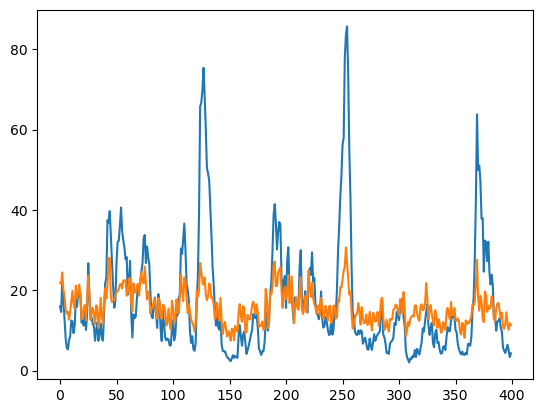

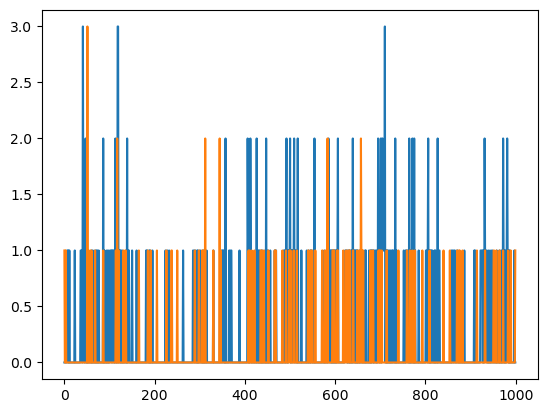

In [12]:
# F = torch.functional.F.softplus(rec_model.gen_model.C.detach().cpu() @ rec_model.gen_model.W.detach().cpu() @ z_train_inferred  + rec_model.gen_model.d.detach().cpu()[:, None])
# # F = rec_model.gen_model.C.detach().cpu() @ rec_model.gen_model.W.detach().cpu() @ z_train_inferred  + rec_model.gen_model.d.detach().cpu()[:, None]
# for neuron in [0,12]:
#     _F = F[:, neuron, :].flatten() / 0.025
#     plt.plot(_F[1200:1600])
# plt.title('Train firing rate (directly using mean inferred z)')
# plt.show()


X = rec_model.gen_model.W.detach().cpu() @ z_train_inferred_samps
X_samps = X + np.linalg.cholesky(rec_model.gen_model.R[0].detach().cpu().numpy()) @ np.random.randn(*X.shape)
F_samps_tilde = rec_model.gen_model.C.detach().cpu() @ X_samps  + rec_model.gen_model.d.detach().cpu()[:, None]
F_samps = torch.functional.F.softplus(F_samps_tilde)
print(F_samps.shape, 'f samps shape')
F = F_samps.mean(dim=0)
for neuron in [0,12]:
    _F = F[:, neuron, :].flatten() / 0.025
    plt.plot(_F[1200:1600])
plt.title('Train firing rate (mean) from samples')
plt.show()

F = rec_model.get_firing_rates(z_train_inferred_samps)[0].numpy()
for neuron in [0,12]:
    _F = F[:, neuron, :].flatten()
    plt.plot(_F[1200:1600])
plt.show()

# for neuron in [0]:
#     for sample in range(F_samps.shape[0]):
#         _F = F_samps[sample, :, neuron, :].flatten() / 0.025
#         plt.plot(_F[1200:1600])
# plt.title('Train firing rate (samples)')
# plt.show()
# for neuron in [0]:
#     for sample in range(F_samps.shape[0]):
#         _X = F_samps_tilde[sample, :, neuron, :].flatten()
#         plt.plot(_X[1200:1600])
# plt.title('Train X (samples)')
# plt.show()


# dist = torch.distributions.NegativeBinomial(total_count=rec_model.gen_model.lik.total_count[None, :, None], logits=F)
# plt.plot(dist.mean[0, [0,12]].detach().cpu().numpy().T / 0.025)
# plt.show()
# plt.plot(Y_train[0, [0,10]].detach().cpu().numpy().T)
# plt.show()


F = torch.functional.F.softplus(rec_model.gen_model.C.detach().cpu() @ rec_model.gen_model.W.detach().cpu() @ z_test_inferred  + rec_model.gen_model.d.detach().cpu()[:, None]) / 0.025
for neuron in [0,12]:
    _F = F[:, neuron, :].flatten()
    print(_F.shape)
    plt.plot(_F[1200:1600])
plt.show()

F_samps = torch.functional.F.softplus(rec_model.gen_model.C.detach().cpu() @ rec_model.gen_model.W.detach().cpu() @ z_test_inferred_samps  + rec_model.gen_model.d.detach().cpu()[:, None])
print(F_samps.shape)
F = F_samps.mean(dim=0)
for neuron in [0,12]:
    _F = F[:, neuron, :].flatten() / 0.025
    plt.plot(_F[1200:1600])
plt.show()

# dist = torch.distributions.NegativeBinomial(total_count=rec_model.gen_model.lik.total_count[None, :, None], logits=F)
# plt.plot(dist.mean[0, :100].detach().cpu().numpy().T)
# plt.show()
plt.plot(Y_test[0, [0,10]].detach().cpu().numpy().T)
plt.show()

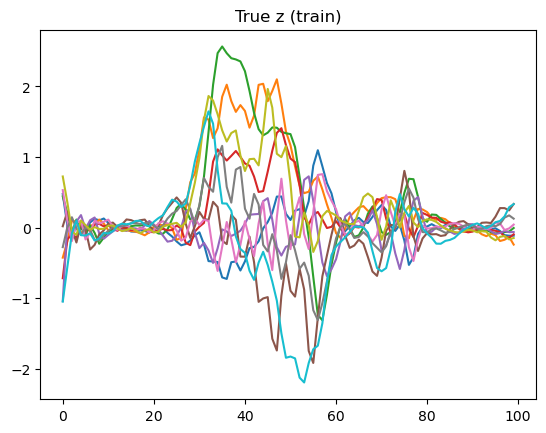

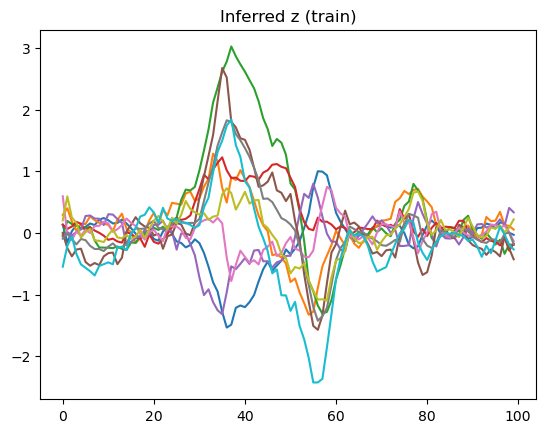

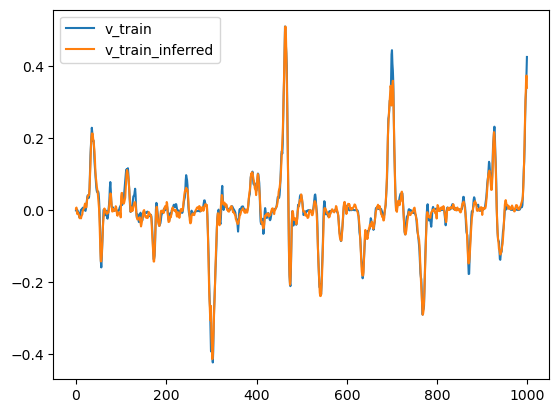

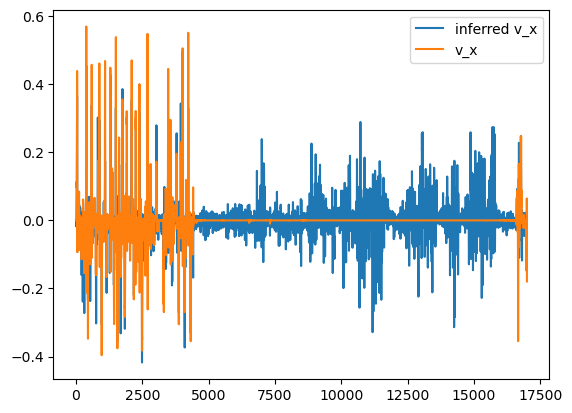

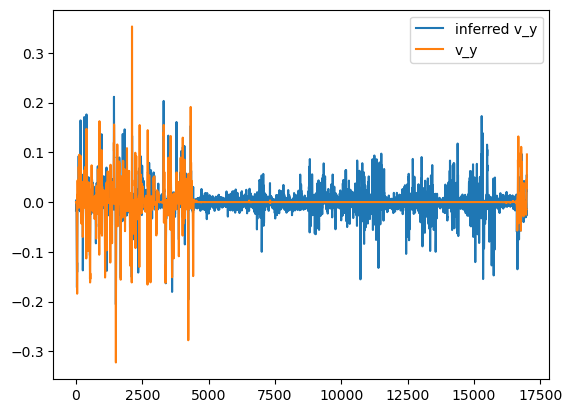

x test 0.6842534334830911 y test 0.6350240276220511 avg 0.659638730552571
x train 0.980145835718328 y train 0.942053611710139 avg 0.9610997237142336
x test 0.5885899194808623 y test 0.6747020307695444 avg 0.6316459751252033 trial 0
x test 0.7904813766064019 y test 0.7848023420272794 avg 0.7876418593168406 trial 1
x test 0.7870794213841696 y test 0.6684620708137139 avg 0.7277707460989418 trial 2
x test 0.7694732659844334 y test 0.5505298634806066 avg 0.66000156473252 trial 3
x test 0.7934538064256377 y test 0.6630849297880803 avg 0.728269368106859 trial 4
x test 0.43817089246068985 y test 0.7453735450334265 avg 0.5917722187470582 trial 5
x test 0.8038857021860563 y test 0.6834437012618506 avg 0.7436647017239535 trial 6
x test 0.8311727827654929 y test 0.6375786826981753 avg 0.7343757327318341 trial 7
x test 0.8119995081745521 y test 0.678809874508153 avg 0.7454046913413526 trial 8
x test 0.7345204356984634 y test 0.5747742192009158 avg 0.6546473274496896 trial 9
x test 0.831624542860894

In [13]:
for trial in range(1):
    if z_train is None:
        z_train = p.get_z_hat(v_train[trial, ...][None, ...].to(device), smoothing=smoothing).detach().cpu().numpy()
    plt.plot(z_train[0, :, :].T)
    plt.title('True z (train)')
    plt.show()

    plt.plot(z_train_inferred[trial, ...].T)
    plt.title('Inferred z (train)')
    plt.show()

if dataset == 'Doherty':
    start = 0
    stop = 1000
    plt.plot(v_train[:,0,:].flatten()[start:stop], label = 'v_train')
    plt.plot(v_train_inferred[:,0,:].flatten()[start:stop], label = 'v_train_inferred')
    plt.legend()
    plt.show()

big_show = False
if big_show:
    for trial in range(1):
        plt.figure(figsize=(15, 5))  # Adjust as needed
        # plt.imshow(_Y_train[trial].T)
        plt.imshow(Y_test[trial].T)
        plt.colorbar()
        plt.title('Spike train (test)')
        plt.show()
        plt.figure(figsize=(15, 5))  # Adjust as needed
        # plt.imshow(rec_model.get_x_tilde(rec_model.gen_model.Y).detach().cpu().numpy()[trial].T)
        pseudo_obs = rec_model.get_x_tilde(Y_test.to(device), only_x_tilde=False)
        x_tilde = pseudo_obs['x_tilde'].detach().cpu().numpy()[trial].T
        plt.imshow(x_tilde)
        # plt.imshow(rec_model.get_x_tilde(Tensor(_Y_test).to(device)).detach().cpu().numpy()[trial].T)
        plt.colorbar(orientation='horizontal')
        plt.title('x_tilde')
        plt.show()
        # rec_model.zero_mean_x_tilde = False
        print(rec_model.get_x_tilde(Y_test.to(device)).detach().cpu().numpy()[trial].shape)
        plt.plot(rec_model.get_x_tilde(Y_test.to(device)).detach().cpu().numpy()[trial].mean(axis=-1))
        plt.title('x_tilde mean')
        plt.show()
        plt.figure(figsize=(15, 5))  # Adjust as needed
        # plt.imshow(rec_model.gen_model.link_fn(model.C @ model.W @ Tensor(z_train[trial]).to(device) + rec_model.gen_model.d[:, None]).detach().cpu().numpy().T)
        plt.imshow(rec_model.gen_model.link_fn(gen_model.C @ gen_model.W @ Tensor(z_test_inferred[trial]).to(device) + rec_model.gen_model.d[:, None]).detach().cpu().numpy().T)
        plt.colorbar()
        plt.title('Firing rate')
        plt.show()

        if pseudo_obs['delta_R'] is not None:
            delta_R = pseudo_obs['delta_R'].detach().cpu().numpy() # (T, ntrials, x_dim)
            for t in range(10):
                plt.plot(delta_R[t, trial, :])
            plt.title('delta_R')
            plt.show()

            if not rec_model.gen_model.full_R:
                plt.plot(rec_model.gen_model.log_sigma_x.detach().cpu().numpy(), label='log_sigma_x')
                plt.legend()
                plt.show()

            new_R = rec_model.gen_model_R(pseudo_obs)[:, trial, ...].detach().cpu().numpy() # (T, x_dim, x_dim)
            R_diag = np.diagonal(new_R, axis1=-1, axis2=-2)
            print(R_diag.shape)
            for t in range(10):
                plt.plot(R_diag[t])
            plt.title('R_diag new')
            plt.show()
            R_orig = rec_model.gen_model_R(pseudo_obs=None).detach().cpu().numpy() # (x_dim, x_dim)
            R_diag_orig = np.diagonal(R_orig, axis1=-1, axis2=-2)
            print(R_diag_orig.shape)
            plt.plot(R_diag_orig)
            plt.title('R_diag orig')
            plt.show()
        if pseudo_obs['delta_W'] is not None:
            delta_W = pseudo_obs['delta_W'].detach().cpu().numpy()
            norms = []
            norms2 = []
            for _trial in range(5):
                norms.append([np.linalg.norm(delta_W[t, _trial] - delta_W[0, _trial], ord='fro') for t in range(16)])
                norms2.append([np.linalg.norm(delta_W[t, _trial], ord='fro') for t in range(16)])
            norms = np.array(norms)
            plt.plot(norms.T)
            plt.title('Frobenius norm of delta_W with respect to first time point')
            plt.show()
            norms2 = np.array(norms2)
            plt.plot(norms2.T)
            plt.title('Frobenius norm of delta_W with respect to true W')
            plt.show()
            
            for t in [0,8,15]:
                plt.figure(figsize=(15, 5))  # Adjust as needed
                # plt.imshow(delta_W[t, trial].T)
                plt.imshow(rec_model.gen_model.W[0].detach().cpu().numpy().T + delta_W[t, trial].T)
                plt.colorbar(orientation='horizontal')
                plt.title('final W')
                plt.show()

# cw_v = np.load('KF.npy')
if dataset == '4g10':
    for trial in range(5):
        plt.plot(v_test_inferred[trial,0,:], label = 'inferred v_x', color='red', linestyle='dotted')
        plt.plot(v_test_inferred[trial,1,:], label = 'inferred v_y', color='blue', linestyle='dotted')
        plt.plot(v_test[trial,0,:], label = 'hand x', color='red')
        plt.plot(v_test[trial,1,:], label = 'hand y', color='blue')
        # plt.plot(cw_v[0,trial,:], label = 'KF x', color='red', linestyle='dashed')
        # plt.plot(cw_v[1,trial,:], label = 'KF y', color='blue', linestyle='dashed')
        plt.legend()
        plt.show()
elif dataset == 'Doherty':
    trials = list(range(40, 57))
    plt.plot(v_test_inferred[trials,0,:].flatten(), label = 'inferred v_x')
    plt.plot(v_test[trials,0,:].flatten(), label = 'v_x')
    plt.legend()
    plt.show()

    plt.plot(v_test_inferred[trials,1,:].flatten(), label = 'inferred v_y')
    plt.plot(v_test[trials,1,:].flatten(), label = 'v_y')
    plt.legend()
    plt.show()

x_test_score = r2_score(v_test[:,0,:].flatten(), v_test_inferred[:,0,:].flatten())
y_test_score = r2_score(v_test[:,1,:].flatten(), v_test_inferred[:,1,:].flatten())
print('x test', x_test_score, 'y test', y_test_score, 'avg', (x_test_score + y_test_score)/2)

# calculate R2 on train data
x_train_score = r2_score(v_train[:,0,:].flatten(), v_train_inferred[:,0,:].flatten())
y_train_score = r2_score(v_train[:,1,:].flatten(), v_train_inferred[:,1,:].flatten())
print('x train', x_train_score, 'y train', y_train_score, 'avg', (x_train_score + y_train_score)/2)

if dataset == 'Doherty':
    for trial in range(v_test_inferred.shape[0]):
        x_test_score = r2_score(v_test[trial,0,:], v_test_inferred[trial,0,:])
        y_test_score = r2_score(v_test[trial,1,:], v_test_inferred[trial,1,:])
        print('x test', x_test_score, 'y test', y_test_score, 'avg', (x_test_score + y_test_score)/2, 'trial', trial)

# x_test_score_cw = r2_score(hand_test[:,0,:].flatten(), cw_v[0].flatten())
# y_test_score_cw = r2_score(hand_test[:,1,:].flatten(), cw_v[1].flatten())
# print('x test cw', x_test_score_cw, 'y test cw', y_test_score_cw, 'avg cw', (x_test_score_cw + y_test_score_cw)/2)